In [63]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
data = pd.read_csv('../data/cleaned_data_ML.csv', index_col=0)

In [3]:
X = data.drop(columns='Heart_Disease')
y = data['Heart_Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2,random_state =123)

In [4]:
y.value_counts()

0.0    268239
1.0     16640
Name: Heart_Disease, dtype: int64

Lets resample the data so theres no class imbalance

In [5]:
from sklearn.utils import resample
# Separate majority and minority classes
df_majority = data[data.Heart_Disease==0]
df_minority = data[data.Heart_Disease==1]
 
# Downsample majority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample without replacement
                                 n_samples=268239,     # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['Heart_Disease'].value_counts()

0.0    268239
1.0    268239
Name: Heart_Disease, dtype: int64

In [6]:
X_up = df_upsampled.drop(columns='Heart_Disease')
y_up = df_upsampled['Heart_Disease']
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X_up, y_up,test_size=.2,random_state =123)

In [7]:
model =  RandomForestClassifier(class_weight='balanced')

In [8]:
model.fit(X_train_up, y_train_up)

RandomForestClassifier(class_weight='balanced')

In [64]:
cf = confusion_matrix(y_test_up, model.predict(X_test_up))

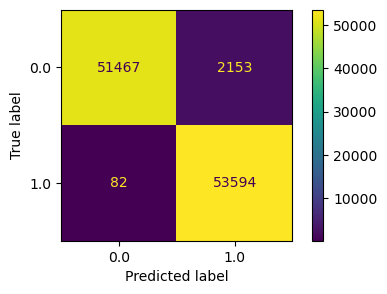

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=model.classes_)
disp.plot()

In [10]:
print(classification_report(y_test_up, model.predict(X_test_up)))

              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     53620
         1.0       0.96      1.00      0.98     53676

    accuracy                           0.98    107296
   macro avg       0.98      0.98      0.98    107296
weighted avg       0.98      0.98      0.98    107296



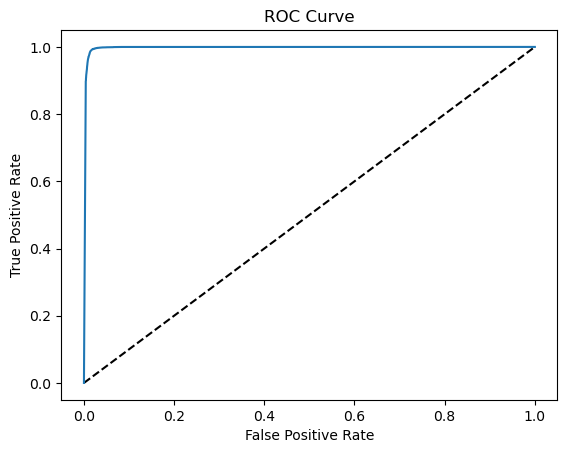

ROC AUC Score:  0.9972636817631721


In [11]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, roc_auc_score

y_predict_probs = model.predict_proba(X_test_up)[:,1]

fpr, tpr, thresholds = roc_curve(y_test_up, y_predict_probs)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('ROC AUC Score: ', roc_auc_score(y_test_up, y_predict_probs))

Lets do Mean Decrease in Impurity (MDI) analysis to find out which Features are are being used as most important to the model

In [16]:
feature_names = [X.columns]

In [12]:
importances = model.feature_importances_

Text(0.5, 0, 'Mean decrease in impurity')

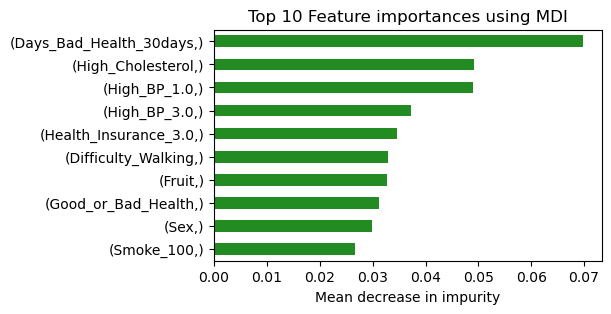

In [61]:
features = pd.Series(importances, index=feature_names)
top_forest_importances = features.sort_values(ascending=False)[:10]

plt.rcParams["figure.figsize"] = (5,3)
fig, ax = plt.subplots()

top_forest_importances.sort_values().plot.barh(ax=ax, color='forestgreen')
ax.set_title("Top 10 Feature importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
